This notebook evaluates the effectiveness of the gradient-based indicators on the test set.

In [1]:
import os
print(os.getcwd())
import torch
import numpy as np
from torchvision import transforms
from src_.utils import load_data, rank_gradient_info, perturbate_s_latents
from src_.backpropagation import generate_image_with_s_latents
from torchvision.utils import save_image

from src.manipulator._style_gan_manipulator.legacy import load_network_pkl
import matplotlib.pyplot as plt
plt.style.use('dark_background')

basepath = "/home/xchen/SMOO/"
data_path = os.path.join(basepath, 'data')
print(data_path, os.path.isdir(data_path))

/tmp/pycharm_project_181
/home/xchen/SMOO/data True


Load the generator and classifier

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device ", device)
ckpt_path = "../local_models/generators/imagenet128.pkl"
# load generator
with open(ckpt_path, 'rb') as f:
    generator = load_network_pkl(f)['G_ema'].to(device)

import torchvision.models as models
classifier = models.resnet18(pretrained=True).eval().to(device)

preprocess_classifier = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

device  cuda


/tmp/pycharm_project_181/src/manipulator/_style_gan_manipulator/legacy.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), map_lo

Load all gradient values across the population, and perturbate the channels with the highest gradients.

In [3]:
target_classes = {205: 'flat-coated retriever',
    206: 'curly-coated retriever',
    207: 'golden retriever',
    208: 'Labrador retriever',
    209: 'Chesapeake Bay retriever'}#  {205, 206,207,208,209}
num_samples=200

target_class_id = 205
sample_id = 1
gradient, metadata = load_data(data_path,
                               target_class_id = target_class_id,
                               sample_id = sample_id)

Compare the original image with the generated image with s latents

In [4]:
img_original_tensor = generate_image_with_s_latents(synthesis_net = generator.synthesis,
                      s_latents = gradient)
# compare with loaded image
img_original = img_original_tensor.cpu().detach().numpy()[0]
img_original = img_original.transpose(1, 2, 0)
img_path = os.path.join(data_path, str(target_class_id), str(sample_id), f"image_{sample_id}.png")
img_loaded = plt.imread(img_path)

img_loaded_tensor = torch.from_numpy(img_loaded.transpose(2, 0, 1)).to(device)
prediction_loaded = classifier(preprocess_classifier(img_loaded_tensor.squeeze(0)).unsqueeze(0)).argmax(1)
prediction_original = classifier(preprocess_classifier(img_original_tensor.squeeze(0)).unsqueeze(0)).argmax(1)

print(prediction_original.cpu().detach().numpy()[0], prediction_loaded.cpu().detach().numpy()[0])

Setting up PyTorch plugin "filtered_lrelu_plugin"... 

/home/xchen/.conda/envs/stylegan3/lib/python3.9/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
205 205


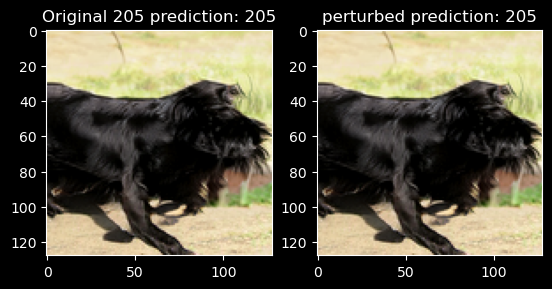

In [5]:
def plot_compare_images(img_original: np.ndarray,
                        img_perturbated:  np.ndarray,
                        prediction_original:  torch.Tensor,
                        prediction_perturbed: torch.Tensor
                        ):
    plt.subplot(1, 2, 1)
    plt.imshow(img_original)
    plt.title(f"Original {target_class_id} prediction: {prediction_original.cpu().detach().numpy()[0]}")
    plt.subplot(1, 2, 2)
    plt.imshow(img_perturbated)
    plt.title(f"perturbed prediction: {prediction_perturbed.cpu().detach().numpy()[0]}")
plot_compare_images(img_original, img_original, prediction_original, prediction_original)

In [6]:
gradient_info_by_layer = rank_gradient_info(gradient)
print(gradient_info_by_layer['input.affine'])
print(gradient_info_by_layer)

hello world
{'ranked_indices': [1, 3, 0, 2], 'signs': [1.0, -1.0, -1.0, 1.0]}
{'input.affine': {'ranked_indices': [1, 3, 0, 2], 'signs': [1.0, -1.0, -1.0, 1.0]}, 'L0_36_1024.affine': {'ranked_indices': [3, 41, 579, 543, 274, 391, 507, 439, 120, 632, 215, 997, 408, 871, 96, 338, 891, 677, 226, 314, 464, 833, 766, 141, 330, 906, 912, 976, 931, 449, 915, 259, 905, 91, 768, 828, 64, 312, 145, 842, 447, 665, 24, 356, 581, 853, 527, 331, 913, 761, 643, 538, 266, 417, 662, 128, 789, 15, 431, 0, 639, 51, 227, 335, 923, 500, 553, 281, 883, 486, 552, 839, 296, 19, 794, 767, 728, 446, 483, 745, 513, 771, 731, 656, 210, 621, 271, 61, 738, 244, 993, 744, 1, 626, 506, 582, 798, 236, 742, 284, 421, 550, 623, 12, 323, 211, 398, 605, 98, 275, 1011, 847, 954, 118, 280, 943, 899, 867, 776, 84, 783, 521, 121, 433, 848, 606, 349, 756, 87, 719, 825, 214, 212, 937, 310, 192, 292, 160, 194, 952, 189, 1012, 193, 820, 17, 190, 402, 95, 237, 291, 650, 629, 385, 29, 914, 624, 984, 707, 898, 959, 159, 268, 750, 43

In [37]:
def collect_perturbated_s_latent(target_class_id = 205, sample_id = 1):
    gradient, metadata = load_data(data_path,
                               target_class_id = target_class_id,
                               sample_id = sample_id)
    gradient_info_by_layer = rank_gradient_info(gradient)

    for i in range(27):
        # perturbate the layer Li
        # find layer name containing Li
        li_layers = {key for key in gradient_info_by_layer.keys() if f"L{i}_" in key}
        if not li_layers:
            print(f"No 'L{i}' found")
            continue
        print(list(li_layers)[0])
        layer = list(li_layers)[0]
        gradient_info = gradient_info_by_layer[layer]
        ind = gradient_info['ranked_indices'][0]
        sign = gradient_info['signs'][0]
        print(f"Layer: {layer}, Ranking: {0}, Index: {ind}")

        # perturbate - sign*0.1
        extent = -10
        gradient_perturbed = perturbate_s_latents(gradient, layer, ind, sign*extent)
        img_perturbed_tensor = generate_image_with_s_latents(synthesis_net = generator.synthesis,
                      s_latents = gradient_perturbed)
        prediction_perturbed = classifier(preprocess_classifier(img_perturbed_tensor.squeeze(0)).unsqueeze(0))
        top_probs, top_classes = torch.topk(prediction_perturbed, 2)
        os.makedirs(os.path.join(data_path, str(target_class_id), str(sample_id), "generated"), exist_ok=True)

        output_dir = os.path.join(data_path, str(target_class_id), str(sample_id), "generated")
        save_image(img_perturbed_tensor, os.path.join(output_dir, f"neg_{layer.replace('.', '_')}_{ind}_pre_{int(top_classes[0][0])}.png"))
        metadata = {
            "perturbed_layer": layer,
            "predicted_class": int(top_classes[0][0]),
            "predicted_probability": float(top_probs[0][0]),
            "misclassification": target_class_id != int(top_classes[0][0]),
            "second_predicted_class": int(top_classes[0][1]),
            "second_predicted_probability": float(top_probs[0][1]),
            "extent": extent
        }
        metadata_path = os.path.join(output_dir, f"neg_{layer.replace('.', '_')}_{ind}_pre_{int(top_classes[0][0])}.json")
        with open(metadata_path, "w") as json_file:
            json.dump(metadata, json_file, indent=4)

        # perturbate + sign*1
        extent = 10
        gradient_perturbed = perturbate_s_latents(gradient, layer, ind, sign*extent)
        img_perturbed_tensor = generate_image_with_s_latents(synthesis_net = generator.synthesis,
                      s_latents = gradient_perturbed)
        prediction_perturbed = classifier(preprocess_classifier(img_perturbed_tensor.squeeze(0)).unsqueeze(0))
        top_probs, top_classes = torch.topk(prediction_perturbed, 2)
        os.makedirs(os.path.join(data_path, str(target_class_id), str(sample_id), "generated"), exist_ok=True)

        output_dir = os.path.join(data_path, str(target_class_id), str(sample_id), "generated")
        save_image(img_perturbed_tensor, os.path.join(output_dir, f"pos_{layer.replace('.', '_')}_{ind}_pre_{int(top_classes[0][0])}.png"))
        metadata = {
            "perturbed_layer": layer,
            "predicted_class": int(top_classes[0][0]),
            "predicted_probability": float(top_probs[0][0]),
            "misclassification": target_class_id != int(top_classes[0][0]),
            "second_predicted_class": int(top_classes[0][1]),
            "second_predicted_probability": float(top_probs[0][1]),
            "extent": extent
        }
        metadata_path = os.path.join(output_dir, f"pos_{layer.replace('.', '_')}_{ind}_pre_{int(top_classes[0][0])}.json")
        with open(metadata_path, "w") as json_file:
            json.dump(metadata, json_file, indent=4)
for target_class_id in [205, 206,207,208,209]:
    for sample_id in range(200):
        collect_perturbated_s_latent(target_class_id = target_class_id, sample_id = sample_id)

hello world
L0_36_1024.affine
Layer: L0_36_1024.affine, Ranking: 0, Index: 323
L1_36_1024.affine
Layer: L1_36_1024.affine, Ranking: 0, Index: 637
L2_36_1024.affine
Layer: L2_36_1024.affine, Ranking: 0, Index: 704
L3_36_1024.affine
Layer: L3_36_1024.affine, Ranking: 0, Index: 576
L4_36_1024.affine
Layer: L4_36_1024.affine, Ranking: 0, Index: 945
L5_36_1024.affine
Layer: L5_36_1024.affine, Ranking: 0, Index: 161
L6_36_1024.affine
Layer: L6_36_1024.affine, Ranking: 0, Index: 403
L7_36_1024.affine
Layer: L7_36_1024.affine, Ranking: 0, Index: 574
No 'L8' found
L9_36_1024.affine
Layer: L9_36_1024.affine, Ranking: 0, Index: 848
L10_52_1024.affine
Layer: L10_52_1024.affine, Ranking: 0, Index: 315
L11_52_1024.affine
Layer: L11_52_1024.affine, Ranking: 0, Index: 125
L12_52_1024.affine
Layer: L12_52_1024.affine, Ranking: 0, Index: 82
L13_52_1024.affine
Layer: L13_52_1024.affine, Ranking: 0, Index: 531
L14_52_1024.affine
Layer: L14_52_1024.affine, Ranking: 0, Index: 197
L15_84_1024.affine
Layer: L

In [43]:
import os
import json
import pandas as pd
import seaborn as sns

def collect_data(target_classes, num_samples):
    """Collect JSON metadata into a DataFrame."""
    data = []

    for target_class_id in target_classes:

        for sample_id in range(num_samples):
            original_json_file = os.path.join(data_path, str(target_class_id), str(sample_id), f"metadata_{sample_id}.json")
            with open(original_json_file, "r") as file:
                original_metadata = json.load(file)
            original_predicted_probability= original_metadata["predicted_probability"]
            original_misclassification =  int(original_metadata["predicted_class"]) != target_class_id
            if original_misclassification:
                continue

            generated_path = os.path.join(data_path, str(target_class_id), str(sample_id), "generated")
            if not os.path.exists(generated_path):  # Skip if folder doesn't exist
                print(f"Path not found: {generated_path}")
                continue

            for json_file in os.listdir(generated_path):
                if json_file.endswith(".json"):  # Only process JSON files
                    json_path = os.path.join(generated_path, json_file)

                    # Load the JSON metadata
                    with open(json_path, "r") as file:
                        metadata = json.load(file)

                    # Add metadata to the list
                    data.append({
                        "target_class_id": target_class_id,
                        "sample_id": sample_id,
                        "perturbed_layer": metadata["perturbed_layer"],
                        "extent": metadata["extent"],
                        "predicted_probability": metadata["predicted_probability"],
                        "misclassification": metadata["misclassification"],
                        "probability_drop": metadata["predicted_probability"] -original_predicted_probability
                    })

    # Return the collected data as a DataFrame
    return pd.DataFrame(data)

# Define classes and samples to process
target_classes = [205, 206, 207, 208, 209]
num_samples = 200

# Collect data and analyze
df = collect_data(target_classes, num_samples)


Statistics by Layer:
                     misclassification_rate  average_probability_drop
perturbed_layer                                                      
L0_36_1024.affine                  0.065193                 -0.126730
L10_52_1024.affine                 0.079365                 -0.318501
L11_52_1024.affine                 0.058957                 -0.208989
L12_52_1024.affine                 0.064626                 -0.177330
L13_52_1024.affine                 0.045918                 -0.129790
L14_52_1024.affine                 0.046485                 -0.085668
L15_84_1024.affine                 0.106009                 -0.394630
L16_84_1024.affine                 0.134354                 -0.452179
L17_84_1024.affine                 0.134921                 -0.527723
L18_84_1024.affine                 0.126984                 -0.385659
L19_84_1024.affine                 0.117914                 -0.497931
L1_36_1024.affine                  0.061791                 -0.072057

/tmp/ipykernel_1718306/3503997217.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_by_layer = df.groupby("perturbed_layer").apply(
/tmp/ipykernel_1718306/3503997217.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_by_extent = df.groupby("extent").apply(


In [49]:
def analyze_data(df):
    """
    Analyze the corrected DataFrame, compute misclassification rates,
    and average probability drop by layer and extent sign.
    """
    # Categorize extent into positive or negative
    df["extent_sign"] = df["extent"].apply(lambda x: "positive" if x > 0 else "negative")

    # Group by perturbed_layer to calculate statistics
    stats_by_layer = df[df["extent_sign"] == "positive"].groupby("perturbed_layer").apply(
        lambda x: pd.Series({
            "misclassification_rate": x["misclassification"].mean(),  # Fraction of misclassified samples
            "average_probability_drop": x["probability_drop"].mean(),  # Mean probability
            "std_probability_drop": x["probability_drop"].std()  # drop
        })
    )

    # Group by extent_sign (positive/negative) to calculate statistics
    stats_by_extent = df.groupby("extent").apply(
        lambda x: pd.Series({
            "misclassification_rate": x["misclassification"].mean(),  # Fraction of misclassified samples
            "average_probability_drop": x["probability_drop"].mean(),  # Mean probability drop
            "std_probability_drop": x["probability_drop"].std()  #
        })
    )

    return stats_by_layer, stats_by_extent, df

stats_by_layer, stats_by_extent, df = analyze_data(df)

# Display the results
print("Statistics by Layer:")
print(stats_by_layer)

print("\nStatistics by Extent:")
print(stats_by_extent)

Statistics by Layer:
                     misclassification_rate  average_probability_drop  \
perturbed_layer                                                         
L0_36_1024.affine                  0.053288                  0.350458   
L10_52_1024.affine                 0.053288                  0.409451   
L11_52_1024.affine                 0.029478                  0.508395   
L12_52_1024.affine                 0.034014                  0.653019   
L13_52_1024.affine                 0.020408                  0.749773   
L14_52_1024.affine                 0.019274                  0.876377   
L15_84_1024.affine                 0.045351                  0.693041   
L16_84_1024.affine                 0.056689                  0.772519   
L17_84_1024.affine                 0.055556                  0.675198   
L18_84_1024.affine                 0.040816                  0.922818   
L19_84_1024.affine                 0.048753                  0.654893   
L1_36_1024.affine             

/tmp/ipykernel_1718306/3622312014.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_by_layer = df[df["extent_sign"] == "positive"].groupby("perturbed_layer").apply(
/tmp/ipykernel_1718306/3622312014.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_by_extent = df.groupby("extent").apply(


/tmp/ipykernel_1718306/269640982.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stats_by_layer.index, y=stats_by_layer["misclassification_rate"], palette="viridis")


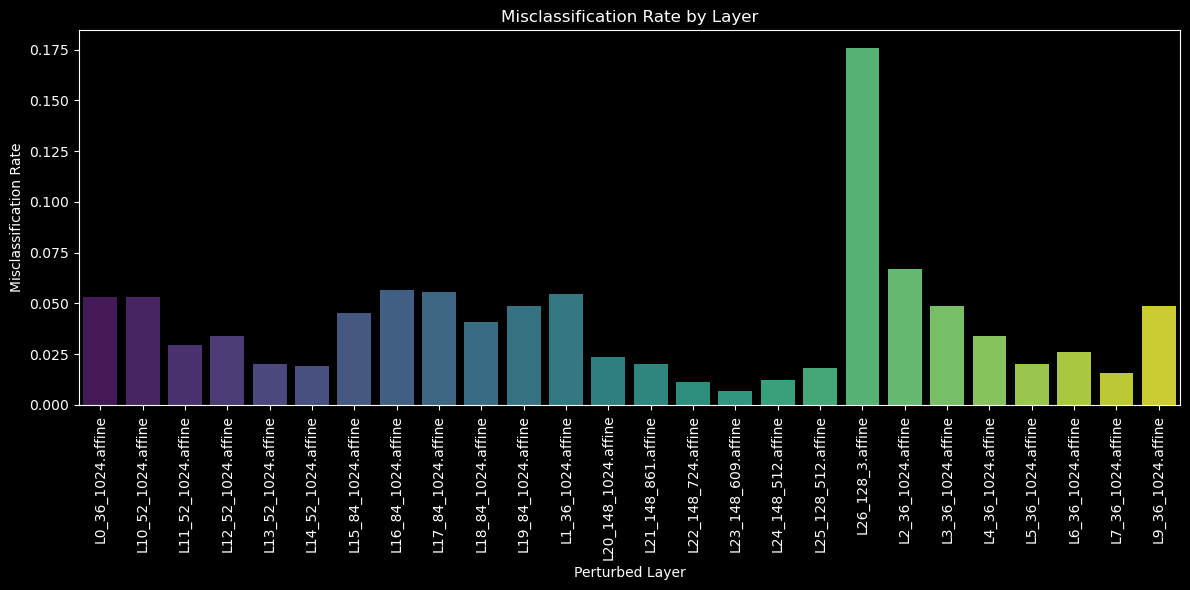

/tmp/ipykernel_1718306/269640982.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="perturbed_layer", y="probability_drop", palette="muted")


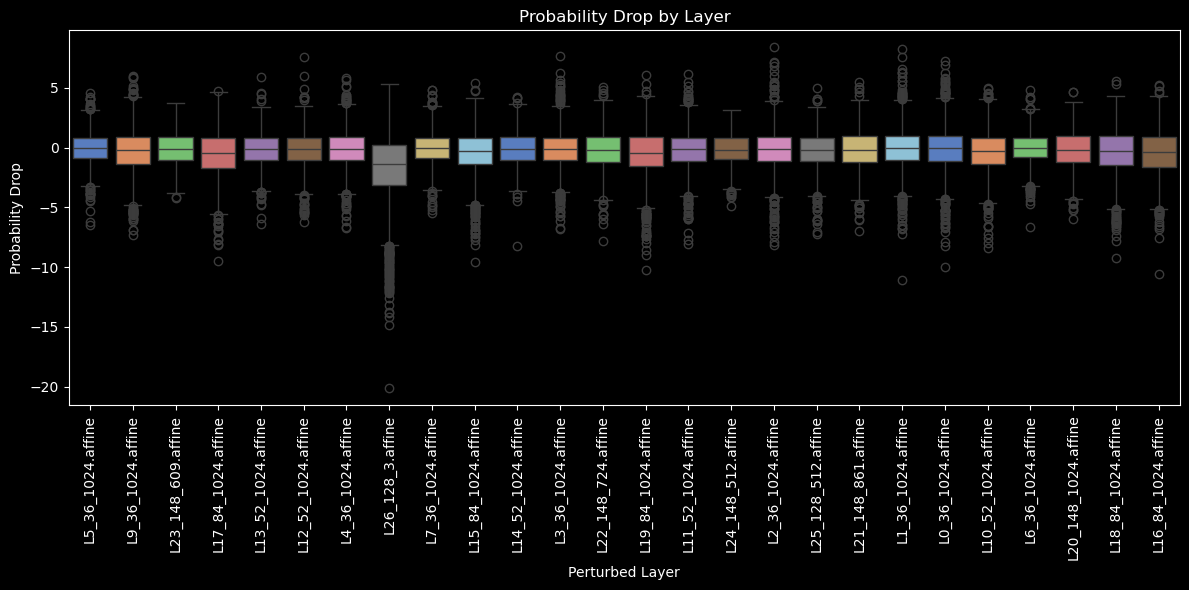

/tmp/ipykernel_1718306/269640982.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="extent", y="probability_drop", palette="coolwarm")


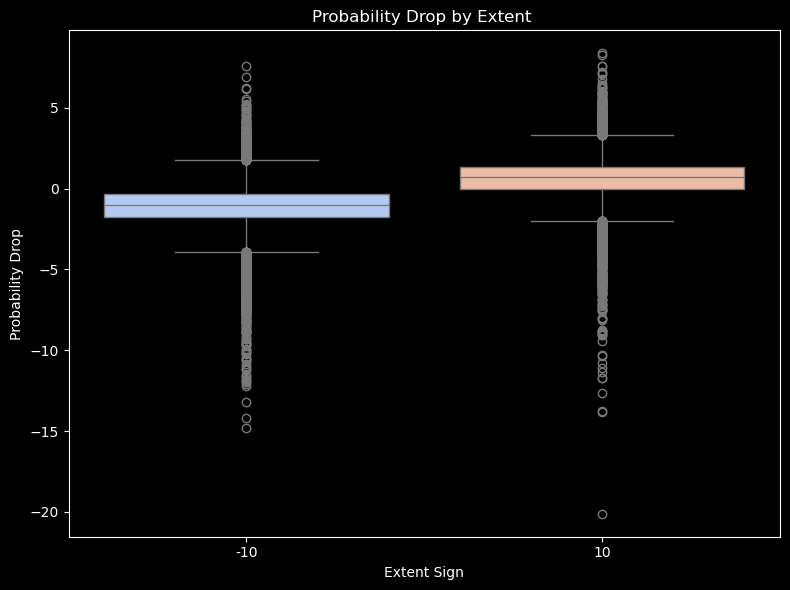

In [52]:
def plot_results(stats_by_layer, df):
    """
    Plot the bar chart for misclassification rates and the boxplots
    for probability drops after fixing probability_drop calculation.
    """
    # Plot 1: Bar chart for misclassification rates by layer
    plt.figure(figsize=(12, 6))

    sns.barplot(x=stats_by_layer.index, y=stats_by_layer["misclassification_rate"], palette="viridis")
    plt.xticks(rotation=90)
    plt.title("Misclassification Rate by Layer")
    plt.xlabel("Perturbed Layer")
    plt.ylabel("Misclassification Rate")
    plt.tight_layout()
    plt.show()

    # Plot 2: Boxplot for probability drop by layer
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x="perturbed_layer", y="probability_drop", palette="muted")
    plt.xticks(rotation=90)
    plt.title("Probability Drop by Layer")
    plt.xlabel("Perturbed Layer")
    plt.ylabel("Probability Drop")
    plt.tight_layout()
    plt.show()

    # Plot 3: Boxplot for probability drop by extent sign
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x="extent", y="probability_drop", palette="coolwarm")
    plt.title("Probability Drop by Extent ")
    plt.xlabel("Extent Sign")
    plt.ylabel("Probability Drop")
    plt.tight_layout()
    plt.show()

plot_results(stats_by_layer, df)

In [ ]:
for layer, indices in indices_by_layer.items():
    for ranking in range(5):
        print(f"Layer: {layer}, Ranking: {ranking}, Index: {indices[ranking]}")
        ind = indices[ranking]
        gradient_perturbed = perturbate_s_latents(gradient, layer, ind)
        img = generate_image_with_s_latents(synthesis_net = generator.synthesis,
                              s_latents = gradient)
        prediction = classifier(img)
        save_image(img, os.path.join(data_path, str(target_class_id), str(sample_id), "generated", f"{layer}_{indices[ranking]}_.png"))

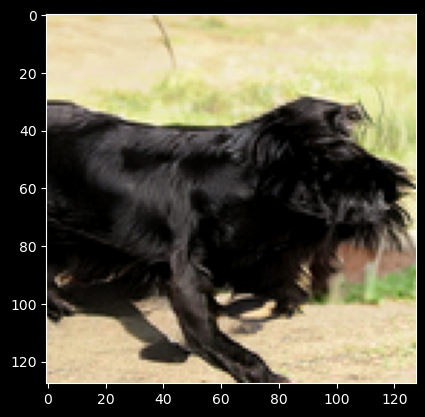

In [29]:
img = generate_image_with_s_latents(synthesis_net = generator.synthesis,
                              s_latents = gradient)

img = img.cpu().detach().numpy()[0]
img = img.transpose(1, 2, 0)
plt.imshow(img)


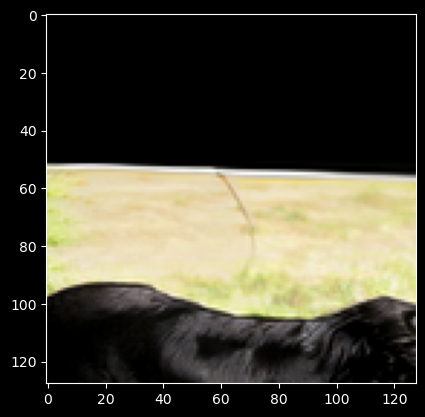

In [30]:
img = generate_image_with_s_latents(synthesis_net = generator.synthesis,
                              s_latents = gradient_perturbed)

img = img.cpu().detach().numpy()[0]
img = img.transpose(1, 2, 0)
plt.imshow(img)
